# Optimizing Website Layout: A/B Testing Analysis #

A cooking website sells cooking equipment. They want to improve their product page. The product page has a rail with media (images or videos). 
Up until now, they have had a horizontal rail, a UX designer suggested having a vertical one. 
As a data analyst in the company, you suggested doing an AB test. 
You now have the results of the test and need to advise the company on whether they should ship the feature (vertical media rail) or not.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
cook_data = pd.read_csv('assessment_da25.csv')
cook_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Variant                2000 non-null   object 
 1   Number of page views   2000 non-null   int64  
 2   GMV (in $)             2000 non-null   float64
 3   Number of add to cart  2000 non-null   int64  
 4   Clicks on media        2000 non-null   int64  
 5   Time on Page (sec)     2000 non-null   int64  
 6   user_id                2000 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 109.5+ KB


## Primary metric: Add-to-cart Rate ##
### Hypothesis ###

Null hypothesis (H0): there is no significance difference in add-to-cart rates between the old and new variants.

Alternative hypothesis (H1): the add-to-cart rate for the new variant is significantly higher than the add-to-cart rate for the old variant

$$ H_0:  µ_A = µ_B $$
$$ H_1:  µ_B > µ_A $$

In [4]:
# Calculate add-to-cart rate for each variant
cook_data['add_to_cart_rate'] = cook_data['Number of add to cart'] / cook_data['Number of page views']

# Create subsets
variant_A = cook_data[cook_data['Variant'] == 'A']
variant_B = cook_data[cook_data['Variant'] == 'B']

add_to_cart_rate_A = variant_A['add_to_cart_rate']
add_to_cart_rate_B = variant_B['add_to_cart_rate']

# I had to clean the data becasue I was getting NaN as add_to_cart_rate.
# There are no missing values, but 0s were causing a division by 0.
add_to_cart_rate_A_clean = add_to_cart_rate_A.dropna().replace([float('inf'), -float('inf')], None)
add_to_cart_rate_B_clean = add_to_cart_rate_B.dropna().replace([float('inf'), -float('inf')], None)

### Plot the add-to-cart rates ###

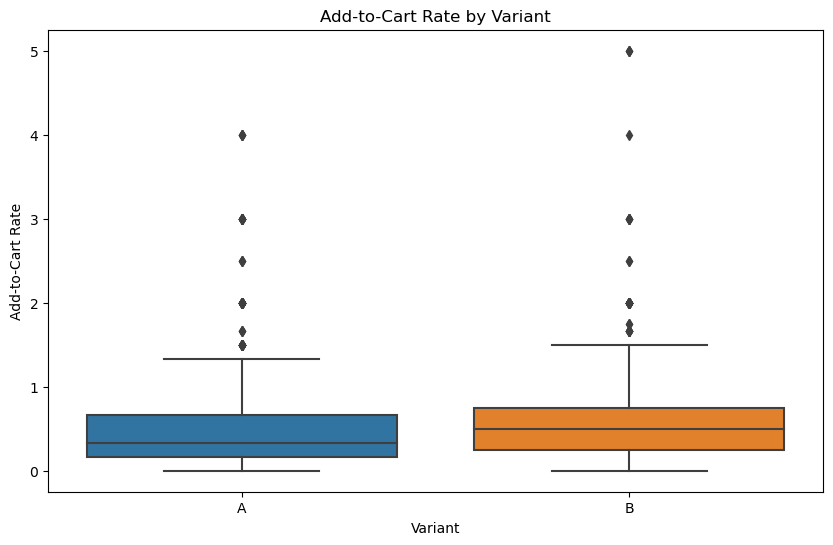

In [5]:
# Plot add-to-cart rate for each variant
plt.figure(figsize = (10, 6))

sns.boxplot(x = 'Variant', y = 'add_to_cart_rate', data = cook_data)

plt.title('Add-to-Cart Rate by Variant')
plt.ylabel('Add-to-Cart Rate')
plt.xlabel('Variant')
plt.show()

Is the add-to-cart rate of Variant B significantly higher than the add-to-cart rate of Variant A?

### Perform a t-test

In [6]:
# Set significance level
alpha = 0.05

# Perform t-test for add-to-cart rate
t_stat, p_value = ttest_ind(add_to_cart_rate_B_clean, add_to_cart_rate_A_clean, alternative = 'greater')

print("T-statistic:", t_stat)
print("P-value:", p_value)
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between Variant A and Variant B.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between Variant A and Variant B.")

T-statistic: 3.0090735892593927
P-value: 0.0013267079778019396
Reject the null hypothesis. There is a significant difference between Variant A and Variant B.


## Secondary metric: Clicks On Media ##
### Hypothesis ###

Null Hypothesis (H0): There is no significant difference in mean clicks on media between Variant A and Variant B

Alternative Hypothesis (H1): The mean clicks on media for Variant B is significantly different (either higher or lower) than the mean clicks on media for Variant A.

$$ H_0 : µ_A -µ_B = 0 $$
$$ H_1: µ_A-µ_B≠0 $$

In [7]:
# Calculate average clicks on media for each variant
average_clicks_A = variant_A['Clicks on media'].mean()
average_clicks_B = variant_B['Clicks on media'].mean()

clicks_media_A = variant_A['Clicks on media']
clicks_media_B = variant_B['Clicks on media']

print("Average number of clicks on items for Variant A:", average_clicks_A)
print("Average number of clicks on items for Variant B:", average_clicks_B)


Average number of clicks on items for Variant A: 1.495
Average number of clicks on items for Variant B: 1.324


### Plot the average clicks on media

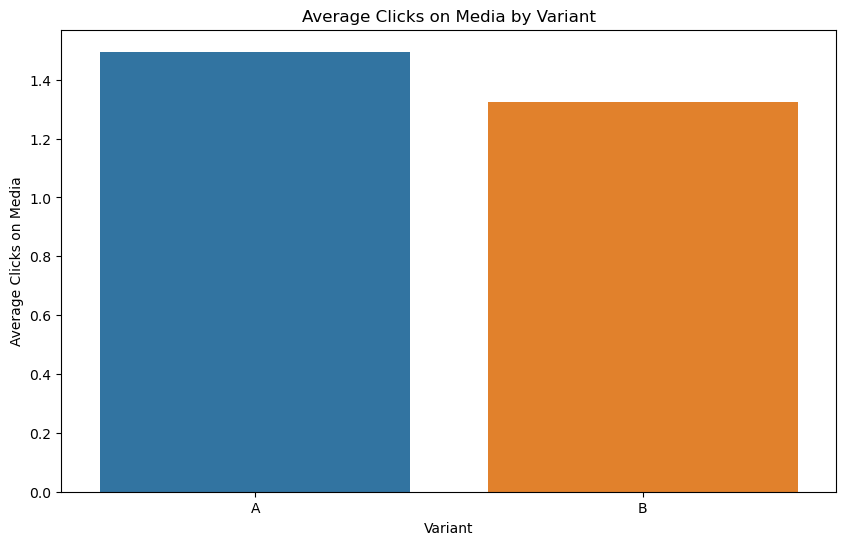

In [8]:
# Plot the average clicks on media for each variant
plt.figure(figsize=(10, 6))

sns.barplot(x=['A', 'B'], y=[average_clicks_A, average_clicks_B])

plt.title('Average Clicks on Media by Variant')
plt.ylabel('Average Clicks on Media')
plt.xlabel('Variant')
plt.show()

Are the average clicks of Variant B significantly different from the average clicks of Variant A?

### Perform a t-test

In [9]:
# Set a significance level
alpha = 0.05

# Perform t-test for clicks on media
t_stat, p_value = ttest_ind(clicks_media_A, clicks_media_B, alternative = "two-sided")
t_stat, p_value

print("T-statistic:", t_stat)
print("P-value:", p_value)
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between Variant A and Variant B.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between Variant A and Variant B.")

T-statistic: 3.1710702328903153
P-value: 0.0015418189281850277
Reject the null hypothesis. There is a significant difference between Variant A and Variant B.


## Secondary metric: Cart Abandonment Rate ##
### Hypothesis ###

Null Hypothesis (H0): There is no significant difference in the cart abandonment rate between Variant A and Variant B.

Alternative Hypothesis (H1): The cart abandonment rate for Variant B is significantly lower than the cart abandonment rate for Variant A.

$$ H_0: µ_A = µ_B $$
$$ H_1: µ_B < µ_A $$

In [61]:
# Calculating cart abandonment rate for each variant
def calculate_abandonment_rate(df):
    abandonments = len(df[(df['Number of add to cart'] > 0) & (df['GMV (in $)'] == 0)])
    added_to_cart = len(df[df['Number of add to cart'] > 0])
    return abandonments / added_to_cart if added_to_cart > 0 else 0

abandonment_rate_A = calculate_abandonment_rate(variant_A)
abandonment_rate_B = calculate_abandonment_rate(variant_B)

print("Abandonment rate for Variant A:", abandonment_rate_A)
print("Abandonment rate for Variant B:", abandonment_rate_B)

Abandonment rate for Variant A: 0.9066511085180864
Abandonment rate for Variant B: 0.8917410714285714


### Plot the comparison of cart-abandonment rates between Variant A and Variant B ###

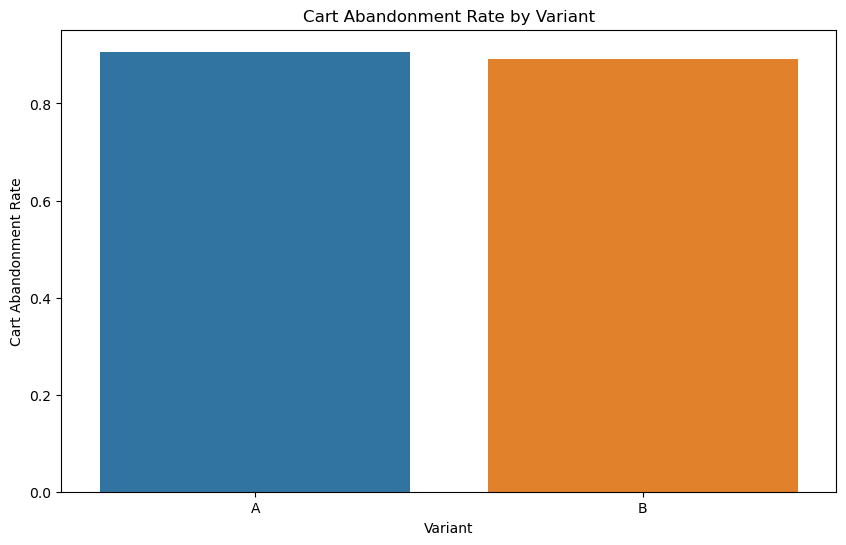

In [53]:
# Plot the cart abandonment rate for each variant
plt.figure(figsize=(10, 6))
sns.barplot(x=['A', 'B'], y=[abandonment_rate_A, abandonment_rate_B])
plt.title('Cart Abandonment Rate by Variant')
plt.ylabel('Cart Abandonment Rate')
plt.xlabel('Variant')
plt.show()

Is the cart-abandonment rate of Variant B significantly lower than the cart-abandonment rate of Variant A?

### Perform a t-test

In [38]:
# Create a binary column for the abandonment rate (abandon the cart = 1, did not abandon = 0)
cook_data['abandonment_rate'] = cook_data.apply(lambda row: 1 if (row['Number of add to cart'] > 0) and (row['GMV (in $)'] == 0) else 0, axis=1)

abandonment_rate_A_data = cook_data[cook_data['Variant'] == 'A']['abandonment_rate']
abandonment_rate_B_data = cook_data[cook_data['Variant'] == 'B']['abandonment_rate']

# Set a significance level
alpha = 0.05

# Perform t-test for cart abandonment rate
t_stat, p_value = ttest_ind(abandonment_rate_B_data, abandonment_rate_A_data, alternative = "less")

print("T-statistic:", t_stat)
print("P-value:", p_value)
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between Variant A and Variant B.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between Variant A and Variant B.")

T-statistic: 1.203418618620162
P-value: 0.8855215336708675
Fail to reject the null hypothesis. There is no significant difference between Variant A and Variant B.


## Other metric: Gross Merchandise Value (GMV) ##
### Hypothesis ###

Null Hypothesis (H0): There is no significant difference in the Gross Merchandise Value (GMV) between Variant A and Variant B.

Alternative Hypothesis (H1): The Gross Merchandise Value (GMV) for Variant B is significantly higher than the Gross Merchandise Value (GMV) for Variant A.

$$ H_0: µ_A = µ_B $$
$$ H_1: µ_B > µ_A $$

In [40]:
gmv_A = variant_A['GMV (in $)']
gmv_B = variant_B['GMV (in $)']

# Calculate the average GMV for each variant
mean_gmv_A = gmv_A.mean()
mean_gmv_B = gmv_B.mean()

print("Average GMV (in $) for Variant A:", mean_gmv_A)
print("Average GMV (in $) for Variant B:", mean_gmv_B)

Average GMV (in $) for Variant A: 7.689989999999999
Average GMV (in $) for Variant B: 9.28953


### Plot the comparison of mean Gross Merchandise Value (GMV) between Variant A and Variant B ###

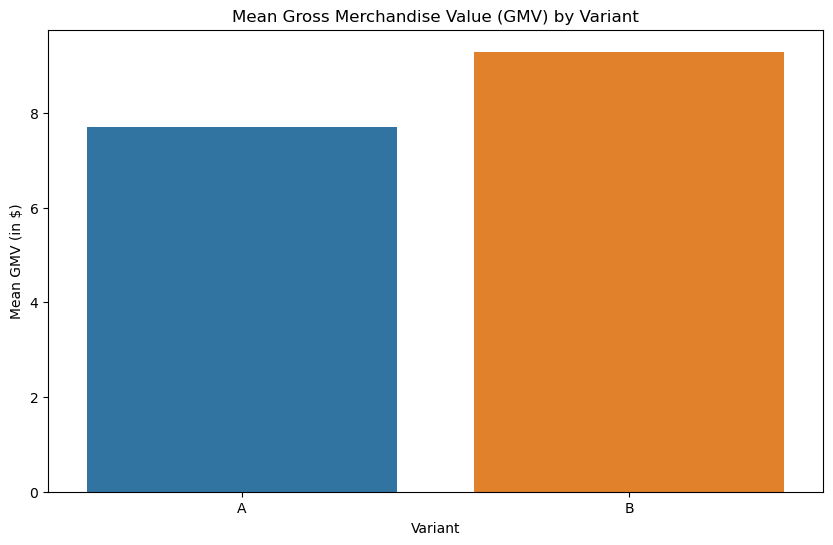

In [73]:
# Plot the average mean of GMV for Variant A and Variant B
plt.figure(figsize=(10, 6))

sns.barplot(x=['A', 'B'], y=[mean_gmv_A, mean_gmv_B])

plt.title('Mean Gross Merchandise Value (GMV) by Variant')
plt.ylabel('Mean GMV (in $)')
plt.xlabel('Variant')
plt.show()


Is the average GMV of Variant B significantly higher than the average GMV in of Variant A?

### Perform a t-test

In [41]:
# Set a significance level
alpha = 0.05

# Perform a t-test
t_stat, p_value = ttest_ind(gmv_B, gmv_A, alternative = 'greater')

print("T-statistic:", t_stat)
print("P-value:", p_value)
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between Variant A and Variant B.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between Variant A and Variant B.")


T-statistic: 1.2839539769831623
P-value: 0.09965346459101122
Fail to reject the null hypothesis. There is no significant difference between Variant A and Variant B.


## Other metric: Number of purchases per user ##
### Hypothesis ###

Null Hypothesis (H0): There is no significant difference in the number of purchases between Variant A and Variant B\

Alternative Hypothesis (H1): The number of purchases on media for Variant B is significantly higher than the number of purchases for Variant A.

$$ H_0: p_A = p_B $$
$$ H_1: p_B > p_A $$

In [43]:
# Number of users with purchases for Variant A and Variant B (GMV > 0 has been countes as one purchase)
purchases_users_a = variant_A[variant_A['GMV (in $)'] > 0]['user_id'].nunique() 
purchases_users_b = variant_B[variant_B['GMV (in $)'] > 0]['user_id'].nunique()

# Total number of users for each variant
total_users_a = variant_A['user_id'].nunique()
total_users_b = variant_B['user_id'].nunique()

# Average purchases per user
avg_purchase_per_user_a = purchases_users_a / total_users_a
avg_purchase_per_user_b = purchases_users_b / total_users_b

print("Proportion of purchases per user for Variant A:", avg_purchase_per_user_a)
print("Proportion of purchases per user for Variant B:", avg_purchase_per_user_b)

Proportion of purchases per user for Variant A: 0.08
Proportion of purchases per user for Variant B: 0.097


### Plot the comparison of mean purchases per user between Variant A and Variant B ###

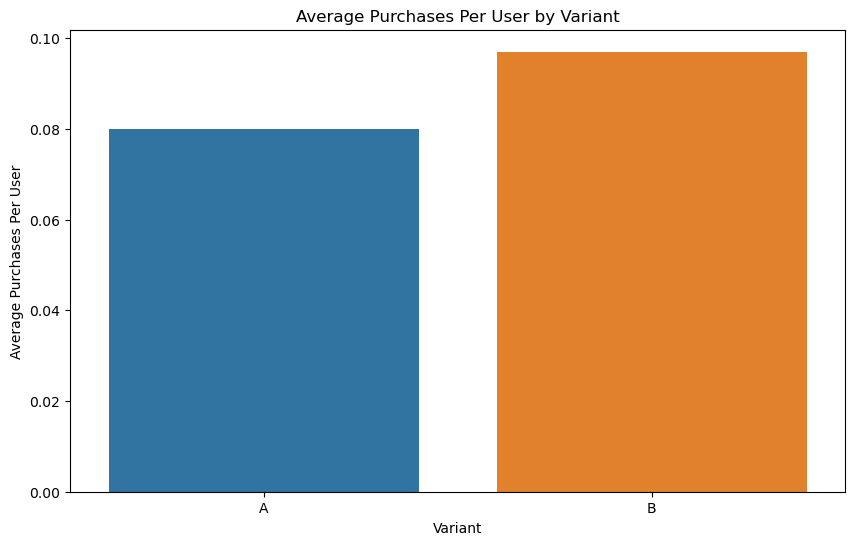

In [85]:
# Plot the average purchases per user
avg_purchases_per_user = [avg_purchase_per_user_a, avg_purchase_per_user_b]

plt.figure(figsize=(10, 6))

sns.barplot(x=['A', 'B'], y=avg_purchases_per_user)

plt.title('Average Purchases Per User by Variant')
plt.ylabel('Average Purchases Per User')
plt.xlabel('Variant')
plt.show()

Is the proportion of purchases per user of Variant B significantly higher than the proportion of purchases per user of Variant A?

### Perform a z-test for proportions

In [44]:
# Set a significance level
alpha = 0.05

# Perform right-tailed z-test for proportions
count = [purchases_users_b, purchases_users_a]
nobs = [total_users_b, total_users_a]
z_stat, p_value = proportions_ztest(count, nobs, alternative = "larger")

print("Z-statistic:", z_stat)
print("P-value:", p_value)
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")

Z-statistic: 1.3383939096387558
P-value: 0.09038403160212077
Fail to reject the null hypothesis. There is no significant difference.
